In [ ]:
import torch, time
from torch.utils.data import DataLoader
from src.utils.imagedata import SpectrumImageDataset, collate_fn
from src.utils.spectrum import read_spectrum, save_spectrum, denorm_spectrum
from src.utils.trainer import DBPNTrainer
from src.utils.visualize import super_resolution_summary
from src.dbpn.dbpn_iterative import Net as DBPNITERNet

- input and parameters

In [2]:
# main input file
input_file = './example_data/375.txt'

# default parameters
batch_size = 1
target_resolution = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

- main code

In [3]:
# main code
model = DBPNITERNet(num_channels=3, base_filter=64, feat=256, num_stages=3, scale_factor=4)
pt_dict = torch.load('./src/dbpn/models/DBPN-RES-MR64-3_4x.pth', map_location='cpu')
pt_dict = {k.replace('module.',''):v for k,v in pt_dict.items()}
md_dict = model.state_dict()
md_dict.update(pt_dict)
model.load_state_dict(md_dict)
model.to(device)
trainer = DBPNTrainer(model=model, opt=None, residual=True, device=device)

dataset = SpectrumImageDataset(upscale_factor=4, data_augmentation=False)

x_inp, y_inp = read_spectrum(input_file)
x = x_inp.copy()
y = y_inp.copy()
for i in range(1,20):
    t1=time.time()
    dataset.from_data(x, y)
    data = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    out = trainer.pred(data)['None_None']
    x = out['x']
    y = denorm_spectrum(out['pred'], out['vmin'], out['vmax'])
    m = 4 ** i
    t = time.time() - t1
    print('Mag.: {}x  / Dim.: {}x{}x{}  / min intensity: {:.2f}  / max intensity: {:.2f}  / Elapsed: {}{}'.format(m, *y.shape, out['vmin'], out['vmax'], f'{t//60:.0f}m' if t > 60 else '', f'{t%60:.2f}s' if t < 10 else f'{t%60:05.2f}s'))
    if y.shape[1] >= target_resolution:
        break

Mag.: 4x  / Dim.: 1600x200x200  / min intensity: 730.17  / max intensity: 8962.87  / Elapsed: 43.03s


- saving final output

In [4]:
# final output: x, y
save_spectrum(x, y, fn=input_file.replace('.txt',f'_{m}x.txt'))

- visualization

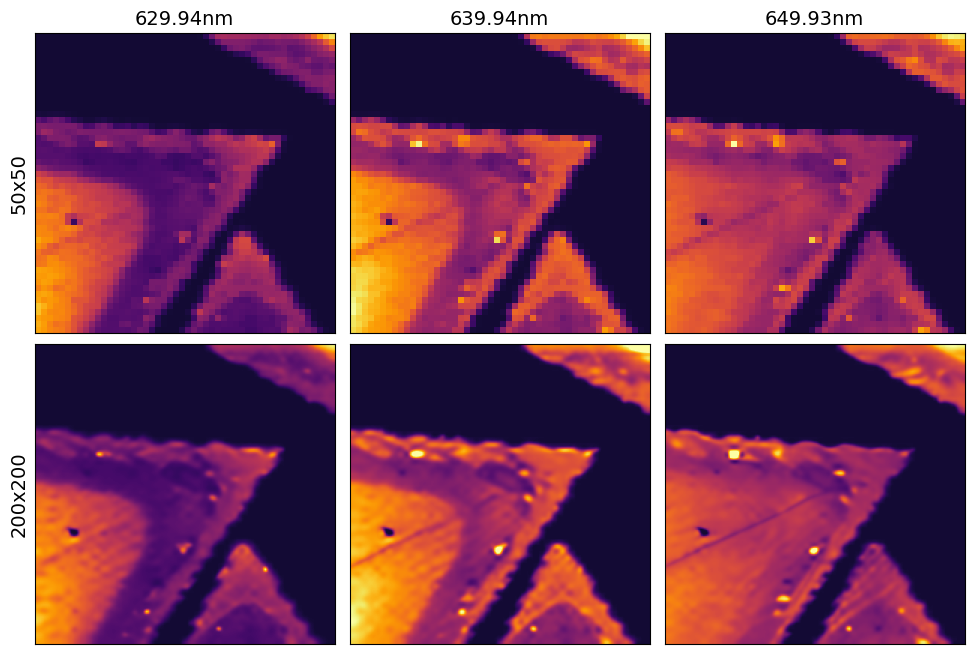

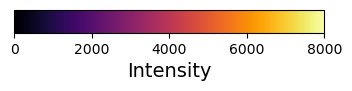

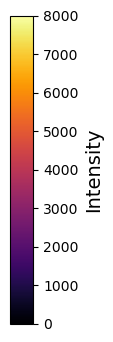

In [5]:
_ = super_resolution_summary(x, y, x_inp, y_inp, locs=[630, 640, 650], intensity_range=[0,8000])